#Graph Node Classification on PubMed dataset (medium)

---

The Pubmed dataset consists of 19717 scientific publications from PubMed database pertaining to diabetes classified into one of three classes.

The citation network consists of 44338 links. Each publication in the dataset is described by a TF/IDF weighted word vector from a dictionary which consists of 500 unique words.

In [ ]:
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set device to gpu if available
import torch
device = 'cpu'
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  

All good, a Gpu is available


In [ ]:
!nvidia-smi

Tue Jun 21 15:41:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric
!pip install -q ogb

     |████████████████████████████████| 7.9 MB 3.9 MB/s 
     |████████████████████████████████| 3.5 MB 4.3 MB/s 
     |████████████████████████████████| 407 kB 4.3 MB/s 
     |████████████████████████████████| 78 kB 3.0 MB/s 


In [ ]:
# Import modules
import networkx as nx
from torch_geometric.utils.convert import to_networkx

from tqdm import tqdm
import time
import sys
import os
import math
import random

import torch.nn.functional as F

import numpy as np

import pandas as  pd

import matplotlib.pyplot as plt
from matplotlib import cm, colors

from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## Reproducibility
When **developing and debugging** Neural Networks is desirable to have a deterministic behaviour. For this reason, we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disable the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime. 

In [ ]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        

In [ ]:
fix_random(42)

## The dataset

In [ ]:
'''
The citation network datasets “Cora”, “CiteSeer” and “PubMed” from the
“Revisiting Semi-Supervised Learning with Graph Embeddings” paper. Nodes
represent documents and edges represent citation links. Training, validation
and test splits are given by binary masks.
'''
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root="datasets", name="PubMed", split="full")

Processing...
Done!


In [ ]:
data = dataset[0]

In [ ]:
from community import community_louvain

G = to_networkx(data, to_undirected=True)

# Added features inferred from the graph topology
pagerank = torch.Tensor(list(nx.pagerank(G).values()))
louvain = torch.Tensor(list(community_louvain.best_partition(G).values()))
clustering_coef = torch.Tensor(list(nx.cluster.clustering(G).values()))
betweeness_centrality = torch.Tensor(list(nx.betweenness_centrality(G, k=50).values()))
degree = torch.Tensor([val for (node, val) in G.degree()])

data.x = torch.column_stack((data.x, pagerank, louvain, clustering_coef, betweeness_centrality, degree))
NUM_FEATURES = dataset.num_features + 5

In [ ]:
import torch_geometric.transforms as T

transform = T.Compose([
    T.NormalizeFeatures()
])
data = transform(data)

In [ ]:
print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {NUM_FEATURES}')
print(f'Number of classes: {dataset.num_classes}')

print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
avg_degree = data.num_edges // data.num_nodes
print(f'Average node degree: {avg_degree}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PubMed():
Number of graphs: 1
Number of features: 505
Number of classes: 3

Data(x=[19717, 505], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4
Number of training nodes: 18217
Training node label rate: 0.924
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Let's see if class are balanced or not across the splits:

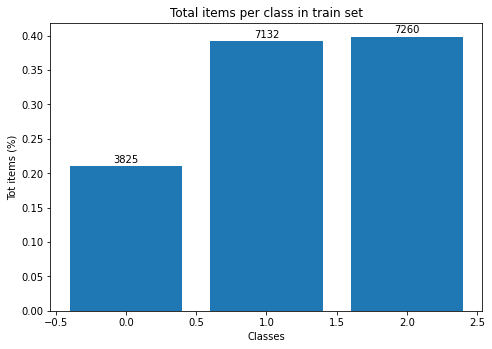

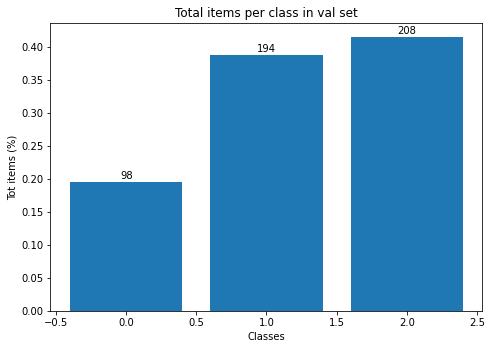

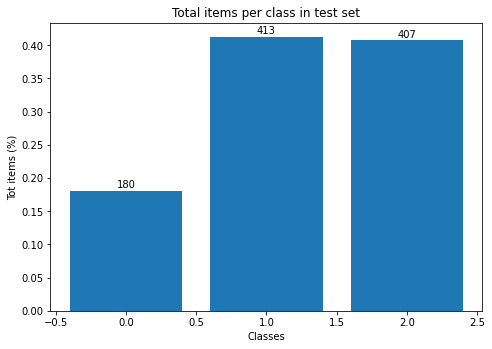

In [ ]:
def plot_total_per_class(dataset, split):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    classes = [c for c in range(dataset.num_classes)]
    totals = [0 for c in range(dataset.num_classes)]

    for i in range(len(dataset)):
        graph = dataset[i]
        split_mask = {
        'train' : graph.train_mask,
        'val': graph.val_mask,
        'test': graph.test_mask,
        }
        items = [graph.y[split_mask[split]].tolist().count(i) for i in classes ]
        totals = [x + y for x, y in zip(totals, items)]

    normalized_totals = [float(x) / np.sum(totals) for x in totals]
    bars = ax.bar(classes, normalized_totals)

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + .005, totals[i], ha='center')

    plt.xlabel('Classes')
    plt.ylabel('Tot items (%)')
    plt.title(f"Total items per class in {split} set")
    plt.show()

    return normalized_totals

normalized_totals_train = plot_total_per_class(dataset, 'train')
normalized_totals_val   = plot_total_per_class(dataset, 'val')
normalized_totals_test  = plot_total_per_class(dataset, 'test')

In [ ]:
'''
ClusterData Clusters/partitions a graph data object into multiple subgraphs.
ClusterLoader merges partioned subgraphs and their between-cluster links from
a large-scale graph data object to form a mini-batch.

Note: requires too much RAM memory to run for AmazonProducts on Colab
'''
from torch_geometric.loader import ClusterData, ClusterLoader
cluster_data = ClusterData(
    data,
    num_parts=100,
    recursive=False,
    save_dir=dataset.processed_dir
)
loader = ClusterLoader(
    cluster_data,
    batch_size=512,
    shuffle=True,
    num_workers=12)

Computing METIS partitioning...
Done!


In [ ]:
batch_data_sample = next(iter(loader))
print(f'Batch sample: {batch_data_sample}')
print(f'Num of iterations per eppch: {len(loader)}')

Batch sample: Data(x=[19717, 505], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717], edge_index=[2, 88648])
Num of iterations per eppch: 1


---

In [ ]:
'''
A weighted random sampler that randomly samples elements according to class
distribution. As such, it will either remove samples from the majority class
(under-sampling) or add more examples from the minority class (over-sampling).
'''
from torch_geometric.loader import ImbalancedSampler
sampler = ImbalancedSampler(
    data,
    input_nodes=data.train_mask
)

In [ ]:
'''
NeighborLoader allows for mini-batch training of GNNs on large-scale graphs
where full-batch training is not feasible.
More specifically, num_neighbors denotes how much neighbors are sampled for
each node in each iteration.
NeighborLoader takes in this list of num_neighbors and iteratively samples
num_neighbors[i] for each node involved in iteration i - 1.
Also, allows to specify a sampler that implements the logic to sample neighbors
(NeighborSampler is the default)
'''
from torch_geometric.loader import NeighborLoader

loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    batch_size=512,
    num_neighbors=[-1]*3, # [-1] to sample all neighbors
    sampler=sampler
)

In [ ]:
batch_data_sample = next(iter(loader))
print(f'Batch sample: {batch_data_sample}')
print(f'Num of iterations per eppch: {len(loader)}')

Batch sample: Data(x=[17434, 505], edge_index=[2, 70836], y=[17434], train_mask=[17434], val_mask=[17434], test_mask=[17434], batch_size=512)
Num of iterations per eppch: 36


---

In [ ]:
'''
The GraphSAINT sampler base class from the “GraphSAINT: Graph Sampling Based
Inductive Learning Method” paper. Given a graph in a data object, this class
samples nodes and constructs subgraphs that can be processed in a mini-batch fashion.
'''
from torch_geometric.loader import GraphSAINTRandomWalkSampler
loader = GraphSAINTRandomWalkSampler(
    data,
    batch_size=512,
    walk_length=3,
    num_steps=5,
    sample_coverage=10,
    save_dir=dataset.processed_dir,
    num_workers=12
)

In [ ]:
batch_data_sample = next(iter(loader))
print(f'Batch sample: {batch_data_sample}')
print(f'Num of iterations per eppch: {len(loader)}')

Batch sample: Data(num_nodes=1654, edge_index=[2, 4902], x=[1654, 505], y=[1654], train_mask=[1654], val_mask=[1654], test_mask=[1654], node_norm=[1654], edge_norm=[4902])
Num of iterations per eppch: 5


---

# Model Definition

**GATv2**

Popular GNN architectures weigh all neighbors $j \in N_{i}$ with equal importance (e.g., mean or max-pooling as AGGREGATE). To
address this limitation, GAT computes a score
for every edge $(j, i)$, which indicates the importance of the features of the neighbor $j$ to the node $i$.

GAT convolution is matematically defined as:

$$ x_{i}^{'} = \alpha_{i,j} \Theta x_{i} + \sum_{j \in \mathcal{N}(i)} \alpha_{i,j} \Theta x_{j}$$

the scoring function is defined as:

$$ e(x_{i}, x_{j}) =  \text{LeakyReLU}(a^\top \cdot [\Theta x_{i} || \Theta x_{j}]) $$

and is used to compute the attention coefficients:

$$ \alpha_{i,j} = \text{softmax}_{j}(e(x_{i}, x_{j})) =  \frac{\exp(e(x_{i}, x_{j}))}{\sum_{j^{'} \in \mathcal{N}} \exp(e(x_{i}, x_{j^{'}}))} $$


The main problem in the standard GAT scoring function  is that the learned layers $\Theta$ and $a$ are applied consecutively, and thus can be collapsed into a single linear layer. To fix
this limitation, in GATv2 the $a$ layer is applied after the nonlinearity (LeakyReLU), and the $\Theta$ layer
after the concatenation, effectively applying an MLP to compute the score for each query-key pair:

$$ e(x_{i}, x_{j}) =  a^\top \text{LeakyReLU}(\Theta \cdot [x_{i} ||  x_{j}]) $$

In [ ]:
from torch_geometric.nn.conv import GATv2Conv
from torch.nn import Sequential, Linear, Dropout
from torch_geometric.nn.norm import BatchNorm

class ParametrizedGATNet(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop=0.5, n_layers=2, n_heads=3, skip_conn=False, post_proc_MLP=False, return_embedding=False):
        super(ParametrizedGATNet, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')

        self.p_drop = p_drop
        self.skip_conn = skip_conn
        self.return_embedding = return_embedding

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        for i in range(n_layers):
            conv = GATv2Conv(in_dim, hid_dim, heads=n_heads, concat=True)
            in_dim = hid_dim * n_heads
            bn = BatchNorm(in_dim)
            self.convs.append(conv)
            self.bns.append(bn)
            
        self.post_proc_MLP = post_proc_MLP
        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(in_dim, hid_dim), Dropout(self.p_drop),
                Linear(hid_dim, out_dim)
            )
        else:
            self.convs[-1] = GATv2Conv(in_dim, out_dim, heads=n_heads, concat=False)
            self.bns[-1] = BatchNorm(out_dim)


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        x_prev = None
        for (conv, bn) in zip(self.convs[:-1], self.bns[:-1]):
            x = conv(x, edge_index)
            x = bn(x)

            if self.skip_conn and x_prev is not None:
                x = torch.add(x, x_prev)
            
            x = F.relu(x)
            x = F.dropout(x, p=self.p_drop, training=self.training)
            x_prev = x
            
        if self.post_proc_MLP:
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)
            embedding = x
            x = self.post_MLP(x)
        else:
            embedding = x
            x = self.convs[-1](x, edge_index)
            x = self.bns[-1](x)

        prediction = F.log_softmax(x, dim=1)

        if self.return_embedding:
            return prediction, embedding
        else:
            return prediction

# Train and Evaluation

In [ ]:
def train(model, optimizer, loss_fn):
    model.train()

    total_loss = total_examples = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index)
        loss = F.nll_loss(out[batch.train_mask], batch.y[batch.train_mask])

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_nodes
        total_examples += batch.num_nodes
    return total_loss / total_examples

In [ ]:
@torch.no_grad()
def test(model):
    model.eval()

    out = model(data.x.to(device), data.edge_index.to(device))
    pred = out.argmax(dim=-1)
    correct = pred.eq(data.y.to(device))

    accs = []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(correct[mask].sum().item() / mask.sum().item())
    return accs

In [ ]:
def train_eval(model, optimizer, criterion, trials=1, epochs=20):

    start_time_sec = time.time()

    best_model_weights = None
    best_model_history = None

    best_test_acc = 0

    for trial in range(trials):

        model.reset_parameters()

        trigger_times = 0
        last_val_acc = 0

        history = {}
        history['train_loss'] = []
        history['train_acc'] = []
        history['val_acc'] = []
        history['test_acc'] = []
        
        pbar = tqdm(range(epochs))
        for epoch in pbar:

            loss = train(model, optimizer, criterion)

            accs = test(model)

            description = f'Epoch: {epoch:02d}, Train loss: {loss:.4f}, Train acc: {accs[0]:.4f}, Val acc: {accs[1]:.4f}, Test acc: {accs[2]:.4f}'
            pbar.set_description(description, refresh=True)

            history['train_loss'].append(loss)
            history['train_acc'].append(accs[0])
            history['val_acc'].append(accs[1])
            history['test_acc'].append(accs[2])

            
            last_test_acc = history['test_acc'][-1]
            if last_test_acc > best_test_acc:
                best_test_acc = last_test_acc
                best_model_weights = model.state_dict()
                best_model_history = history

        # END OF TRAINING LOOP
    # END OF TRIALS LOOP
    print(f'\nBest model with test acc: {best_test_acc:.4f}')
        

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print('Time total:     %5.2f sec' % (total_time_sec))

    return best_model_history, best_model_weights

##ClusterLoader

In [ ]:
INPUT_DIM = NUM_FEATURES
OUTPUT_DIM = dataset.num_classes
EPOCHS = 100
NTRIALS = 1
LR = 1e-3
WD = 1e-5

best_test_acc = 0
best_model_history = None
best_model_weight = None

from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [16],
    'DROPOUT' : [0.3],
    'N_LAYERS' : [3],
    'N_HEADS' : [8],
    'SKIP_CONN' : [True, False],
    'POST_PROC_MLP' : [True, False],
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')
    model = ParametrizedGATNet(INPUT_DIM, dict_['HIDDEN_DIM'], OUTPUT_DIM, dict_['DROPOUT'], dict_['N_LAYERS'], dict_['N_HEADS'], dict_['SKIP_CONN'], dict_['POST_PROC_MLP']).to(device)
    criterion = torch.nn.NLLLoss(weight=torch.tensor(normalized_totals_train).float().to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    history, weights = train_eval(model, optimizer, criterion, trials=NTRIALS, epochs=EPOCHS)
    print('------------------')

    if max(history['test_acc']) > best_test_acc:
        best_test_acc = max(history['test_acc'])
        best_parameters = dict_
        best_model_history = history
        best_model_weights = weights

Number of combinations: 4
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Epoch: 99, Train loss: 0.3268, Train acc: 0.6405, Val acc: 0.6380, Test acc: 0.6380: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]



Best model with test acc: 0.7290
Time total:     63.77 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Epoch: 99, Train loss: 0.3398, Train acc: 0.5932, Val acc: 0.5980, Test acc: 0.5730: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s]



Best model with test acc: 0.7830
Time total:     64.79 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Epoch: 99, Train loss: 0.4482, Train acc: 0.7592, Val acc: 0.7520, Test acc: 0.7460: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]



Best model with test acc: 0.7460
Time total:     64.71 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Epoch: 99, Train loss: 0.4473, Train acc: 0.7208, Val acc: 0.7520, Test acc: 0.7350: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Best model with test acc: 0.8520
Time total:     65.66 sec
------------------


In [ ]:
print(f'Best parameters: {best_parameters}')
model = ParametrizedGATNet(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['N_HEADS'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'])
model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {best_test_acc*100:.2f}% accuracy on test set')

Best parameters: {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}

Best model predicts with 85.20% accuracy on test set


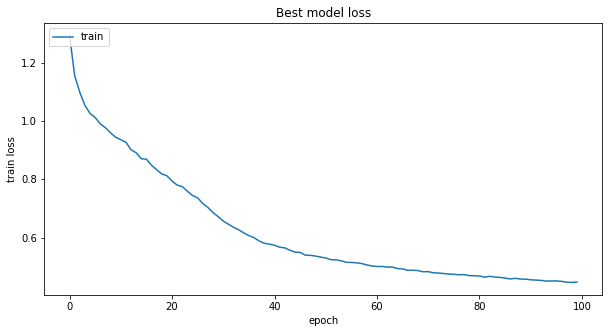

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(best_model_history['train_loss'], label='train')
plt.title('Best model loss')
plt.xlabel('epoch')
plt.ylabel('train loss')
#plt.xticks(range(len(best_model_history['loss'])))
plt.legend(loc='upper left')
plt.show()

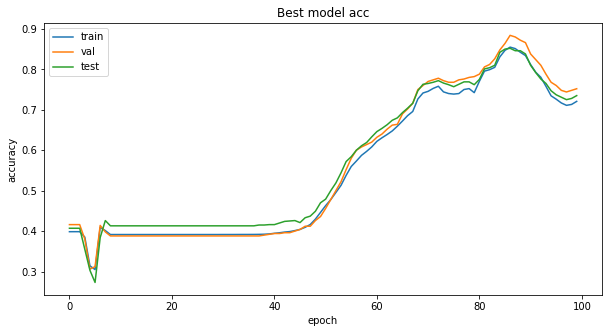

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(best_model_history['train_acc'], label='train')
plt.plot(best_model_history['val_acc'], label='val')
plt.plot(best_model_history['test_acc'], label='test')
plt.title('Best model acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.xticks(range(len(best_model_history['acc'])))
plt.legend(loc='upper left')
plt.show()

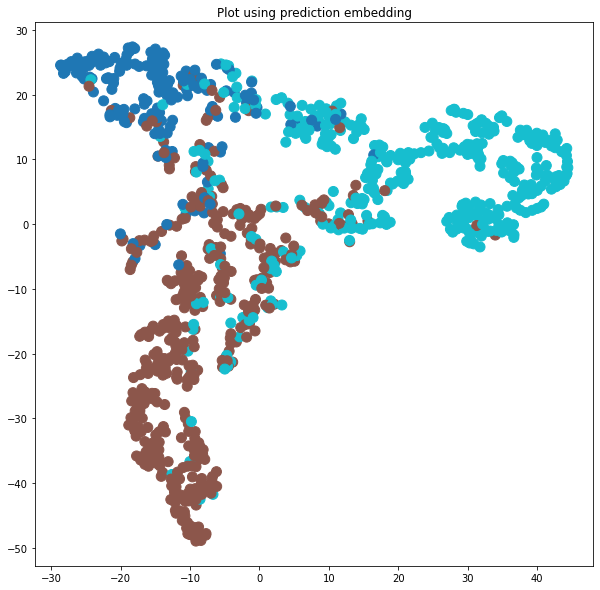

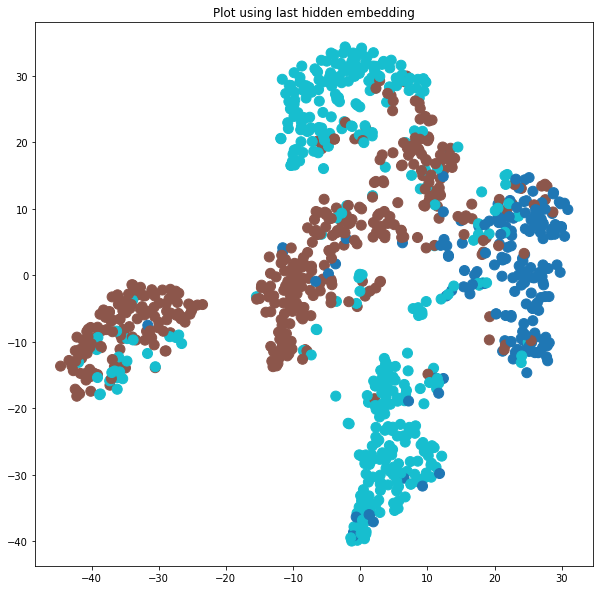

In [ ]:
def plot_embedding2D(h, color=data.y, size=100, title=""):
    h = h.detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    fig = plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.set_cmap("tab10")
    plt.scatter(h[:, 0], h[:, 1], c=color, s=size)
    plt.show()

# Embedding after training
model = ParametrizedGATNet(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['N_HEADS'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'], return_embedding=True).to(device)
model.load_state_dict(best_model_weights)


with torch.no_grad():
    model.eval()
    out, emb = model(data.x.to(device), data.edge_index.to(device))

    plot_embedding2D(out[data.test_mask].cpu(), color=data.y[data.test_mask].cpu(), title="Plot using prediction embedding")
    plot_embedding2D(emb[data.test_mask].cpu(), color=data.y[data.test_mask].cpu(), title="Plot using last hidden embedding")

##NeighborLoader

In [ ]:
INPUT_DIM = NUM_FEATURES
OUTPUT_DIM = dataset.num_classes
EPOCHS = 100
NTRIALS = 1
LR = 1e-3
WD = 1e-5

best_test_acc = 0
best_model_history = None
best_model_weight = None

from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [16],
    'DROPOUT' : [0.3],
    'N_LAYERS' : [3],
    'N_HEADS' : [8],
    'SKIP_CONN' : [True, False],
    'POST_PROC_MLP' : [True, False],
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')
    model = ParametrizedGATNet(INPUT_DIM, dict_['HIDDEN_DIM'], OUTPUT_DIM, dict_['DROPOUT'], dict_['N_LAYERS'], dict_['N_HEADS'], dict_['SKIP_CONN'], dict_['POST_PROC_MLP']).to(device)
    criterion = torch.nn.NLLLoss(weight=torch.tensor(normalized_totals_train).float().to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    history, weights = train_eval(model, optimizer, criterion, trials=NTRIALS, epochs=EPOCHS)
    print('------------------')

    if max(history['test_acc']) > best_test_acc:
        best_test_acc = max(history['test_acc'])
        best_parameters = dict_
        best_model_history = history
        best_model_weights = weights

Number of combinations: 4
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Epoch: 99, Train loss: 0.0127, Train acc: 0.8869, Val acc: 0.8540, Test acc: 0.8450: 100%|██████████| 100/100 [03:20<00:00,  2.01s/it]



Best model with test acc: 0.8940
Time total:     200.55 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Epoch: 99, Train loss: 0.0138, Train acc: 0.8864, Val acc: 0.8580, Test acc: 0.8260: 100%|██████████| 100/100 [03:18<00:00,  1.98s/it]



Best model with test acc: 0.8900
Time total:     198.10 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Epoch: 99, Train loss: 0.0186, Train acc: 0.8479, Val acc: 0.8140, Test acc: 0.8100: 100%|██████████| 100/100 [02:55<00:00,  1.75s/it]



Best model with test acc: 0.8900
Time total:     175.44 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Epoch: 99, Train loss: 0.0203, Train acc: 0.8551, Val acc: 0.8220, Test acc: 0.8180: 100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


Best model with test acc: 0.8830
Time total:     175.00 sec
------------------


In [ ]:
print(f'Best parameters: {best_parameters}')
model = ParametrizedGATNet(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['N_HEADS'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'])
model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {best_test_acc*100:.2f}% accuracy on test set')

Best parameters: {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}

Best model predicts with 89.40% accuracy on test set


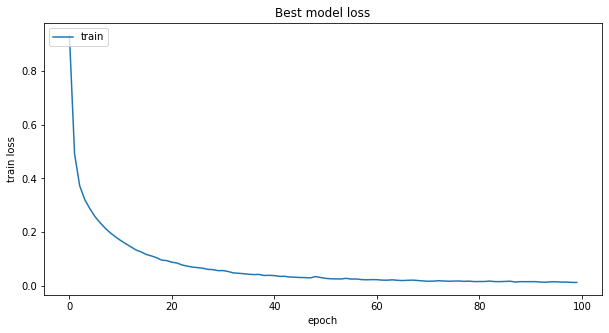

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(best_model_history['train_loss'], label='train')
plt.title('Best model loss')
plt.xlabel('epoch')
plt.ylabel('train loss')
#plt.xticks(range(len(best_model_history['loss'])))
plt.legend(loc='upper left')
plt.show()

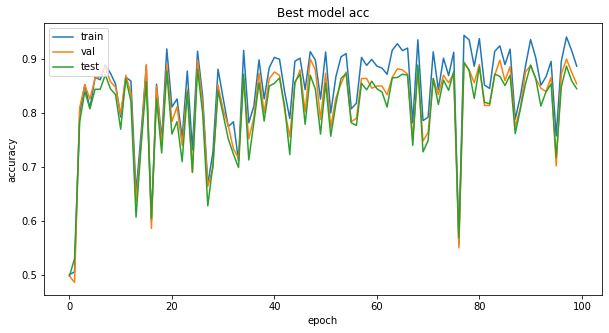

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(best_model_history['train_acc'], label='train')
plt.plot(best_model_history['val_acc'], label='val')
plt.plot(best_model_history['test_acc'], label='test')
plt.title('Best model acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.xticks(range(len(best_model_history['acc'])))
plt.legend(loc='upper left')
plt.show()

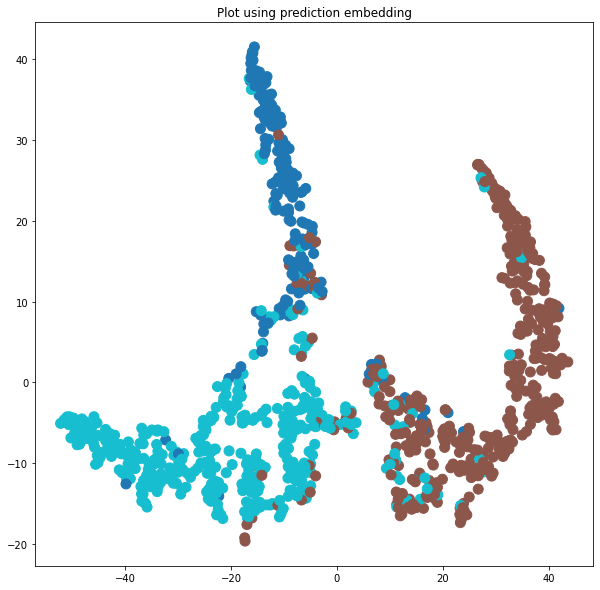

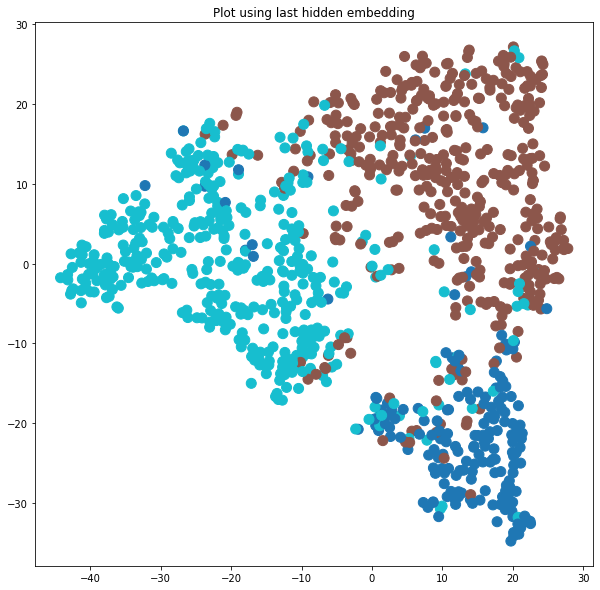

In [ ]:
def plot_embedding2D(h, color=data.y, size=100, title=""):
    h = h.detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    fig = plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.set_cmap("tab10")
    plt.scatter(h[:, 0], h[:, 1], c=color, s=size)
    plt.show()

# Embedding after training
model = ParametrizedGATNet(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['N_HEADS'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'], return_embedding=True).to(device)
model.load_state_dict(best_model_weights)


with torch.no_grad():
    model.eval()
    out, emb = model(data.x.to(device), data.edge_index.to(device))

    plot_embedding2D(out[data.test_mask].cpu(), color=data.y[data.test_mask].cpu(), title="Plot using prediction embedding")
    plot_embedding2D(emb[data.test_mask].cpu(), color=data.y[data.test_mask].cpu(), title="Plot using last hidden embedding")

##GraphSAINT Random Walk

In [ ]:
INPUT_DIM = NUM_FEATURES
OUTPUT_DIM = dataset.num_classes
EPOCHS = 100
NTRIALS = 1
LR = 1e-3
WD = 1e-5

best_test_acc = 0
best_model_history = None
best_model_weight = None

from sklearn.model_selection import ParameterGrid
configs = {
    'HIDDEN_DIM' : [16],
    'DROPOUT' : [0.3],
    'N_LAYERS' : [3],
    'N_HEADS' : [8],
    'SKIP_CONN' : [True, False],
    'POST_PROC_MLP' : [True, False],
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')
    model = ParametrizedGATNet(INPUT_DIM, dict_['HIDDEN_DIM'], OUTPUT_DIM, dict_['DROPOUT'], dict_['N_LAYERS'], dict_['N_HEADS'], dict_['SKIP_CONN'], dict_['POST_PROC_MLP']).to(device)
    criterion = torch.nn.NLLLoss(weight=torch.tensor(normalized_totals_train).float().to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
    history, weights = train_eval(model, optimizer, criterion, trials=NTRIALS, epochs=EPOCHS)
    print('------------------')

    if max(history['test_acc']) > best_test_acc:
        best_test_acc = max(history['test_acc'])
        best_parameters = dict_
        best_model_history = history
        best_model_weights = weights

Number of combinations: 4
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}


Epoch: 99, Train loss: 0.3216, Train acc: 0.7955, Val acc: 0.8180, Test acc: 0.7790: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]



Best model with test acc: 0.8710
Time total:     65.71 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': False}


Epoch: 99, Train loss: 0.3279, Train acc: 0.7805, Val acc: 0.7920, Test acc: 0.7690: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]



Best model with test acc: 0.8590
Time total:     68.67 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': True}


Epoch: 99, Train loss: 0.3339, Train acc: 0.8526, Val acc: 0.8560, Test acc: 0.8400: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]



Best model with test acc: 0.8640
Time total:     68.85 sec
------------------
Trying configuration {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': False, 'SKIP_CONN': False}


Epoch: 99, Train loss: 0.3461, Train acc: 0.8260, Val acc: 0.8280, Test acc: 0.8150: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Best model with test acc: 0.8650
Time total:     70.30 sec
------------------


In [ ]:
print(f'Best parameters: {best_parameters}')
model = ParametrizedGATNet(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['N_HEADS'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'])
model.load_state_dict(best_model_weights)
print()
print(f'Best model predicts with {best_test_acc*100:.2f}% accuracy on test set')

Best parameters: {'DROPOUT': 0.3, 'HIDDEN_DIM': 16, 'N_HEADS': 8, 'N_LAYERS': 3, 'POST_PROC_MLP': True, 'SKIP_CONN': True}

Best model predicts with 87.10% accuracy on test set


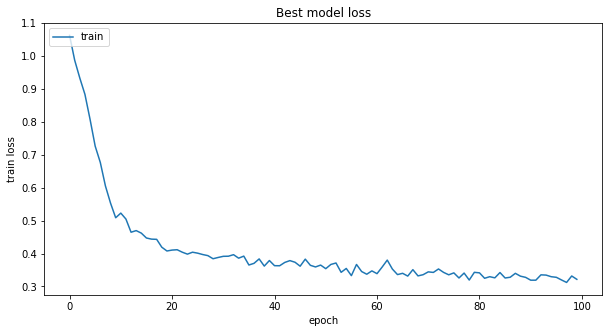

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(best_model_history['train_loss'], label='train')
plt.title('Best model loss')
plt.xlabel('epoch')
plt.ylabel('train loss')
#plt.xticks(range(len(best_model_history['loss'])))
plt.legend(loc='upper left')
plt.show()

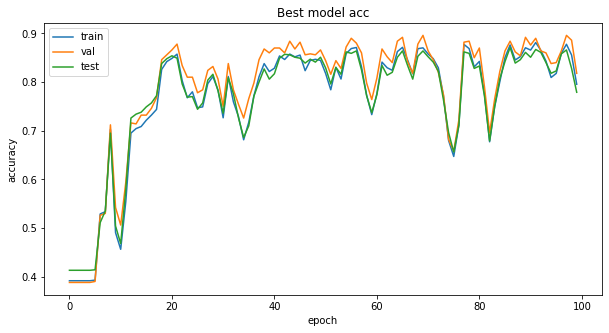

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(best_model_history['train_acc'], label='train')
plt.plot(best_model_history['val_acc'], label='val')
plt.plot(best_model_history['test_acc'], label='test')
plt.title('Best model acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.xticks(range(len(best_model_history['acc'])))
plt.legend(loc='upper left')
plt.show()

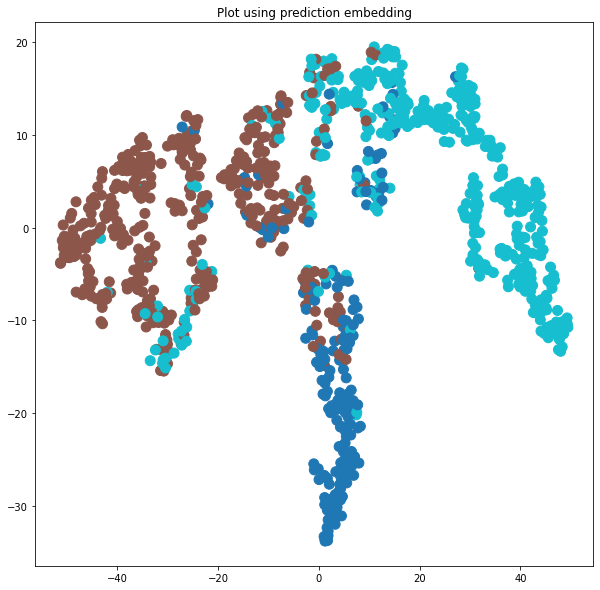

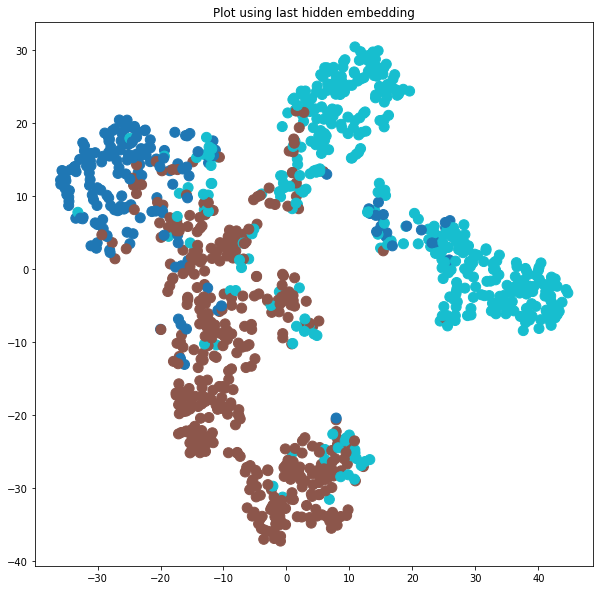

In [ ]:
def plot_embedding2D(h, color=data.y, size=100, title=""):
    h = h.detach().numpy()
    h = TSNE(n_components=2, perplexity=30, n_iter=500, verbose=False).fit_transform(h)
    fig = plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.set_cmap("tab10")
    plt.scatter(h[:, 0], h[:, 1], c=color, s=size)
    plt.show()

# Embedding after training
model = ParametrizedGATNet(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['N_HEADS'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'], return_embedding=True).to(device)
model.load_state_dict(best_model_weights)


with torch.no_grad():
    model.eval()
    out, emb = model(data.x.to(device), data.edge_index.to(device))

    plot_embedding2D(out[data.test_mask].cpu(), color=data.y[data.test_mask].cpu(), title="Plot using prediction embedding")
    plot_embedding2D(emb[data.test_mask].cpu(), color=data.y[data.test_mask].cpu(), title="Plot using last hidden embedding")

#Train and evaluate ML models

## Main ML models tuning
In this section are evaluated the performance of some ML models to see the real improvement in using a GNN model.

Also in this case a fine tuning is performed to evaluate only the best configuration of parameters for each model.

In [ ]:
# X_train and X_test contains the node features
# X_train combines both train and validation splits in order to perform crossvalidation
X_train = pd.DataFrame(data.x[data.train_mask].detach().numpy())
#X_train = X_train.append(pd.DataFrame(data.x[data.val_mask].detach().numpy()))
X_test = pd.DataFrame(data.x[data.test_mask].detach().numpy())
print(f'X_train\tshape: {X_train.shape}\nX_test\tshape: {X_test.shape}')

X_train	shape: (18217, 505)
X_test	shape: (1000, 505)


In [ ]:
# y_train and y_test contains the node labels
y_train = data.y[data.train_mask].detach().numpy().reshape(-1,)
#y_train = np.append(y_train, pd.DataFrame(data.y[data.val_mask].detach().numpy().reshape(-1,)))
y_test = data.y[data.test_mask].detach().numpy().reshape(-1,)
print(f'y_train\tshape: {y_train.shape}\ny_test\tshape: {y_test.shape}')

y_train	shape: (18217,)
y_test	shape: (1000,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Labels for the models
model_lbls = [
    'lr',   # Logistic Regressor
    'rf',   # Random Forest
    'xgb',  # eXtreme Gradient Boost
]

# Set the parameters to be explored for each classifier
tuned_param_lr = [
    {
        'solver': ['lbfgs'],
    },
]
tuned_param_rf = [
    {
        'max_depth': [100],
    },
]
tuned_param_xgb = [
    {
        'objective': ['multi:softmax'],
        'tree_method': ['gpu_hist'],
    },
]

# Set the models to be fitted specifying name, estimator and parameter structure
models = {
    'lr': {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(),
        'param': tuned_param_lr,
    },
    'rf': {
        'name': 'Random Forest',
        'estimator': RandomForestClassifier(), 
        'param': tuned_param_rf,
    },
    'xgb':{
        'name': 'XGBoost',
        'estimator': XGBClassifier(),
        'param': tuned_param_xgb,
    }
}

# Scores to be explored
scores = [
    'precision', 
#    'recall',
]

In [ ]:
def print_results(model):    
    print("Best parameters set found on train set:")
    print()
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    best_score = 0
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, param in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, param))
        if mean > best_score:
          best_score = mean
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    y_pred = model.predict(X_test)
    print(f'Accuracy on test: {accuracy_score(y_test, y_pred, sample_weight=[normalized_totals_test[x] for x in y_test])*100:.2f}%')
    return best_score * 100

In [ ]:
for score in scores:
    print("========================================")
    print("# Tuning hyper-parameters for {}".format(score))
    for model in models:
        print("----------------------------------------")
        print("Trying model {}".format(models.get(model)["name"]))
        start = time.time()
        clf = GridSearchCV(models.get(model)["estimator"], models.get(model)["param"], scoring='%s_macro' % score)
        clf.fit(X_train, y_train)
        print_results(clf)
        end = time.time()
        print(f"Time elapsed: {(end - start):.2f}s")

# Tuning hyper-parameters for precision
----------------------------------------
Trying model Logistic Regression
Best parameters set found on train set:

{'solver': 'lbfgs'}

Grid scores on train set:

0.820 (+/-0.009) for {'solver': 'lbfgs'}

Detailed classification report for the best parameter set:

Accuracy on test: 83.28%
Time elapsed: 26.66s
----------------------------------------
Trying model Random Forest
Best parameters set found on train set:

{'max_depth': 100}

Grid scores on train set:

0.893 (+/-0.006) for {'max_depth': 100}

Detailed classification report for the best parameter set:

Accuracy on test: 91.25%
Time elapsed: 47.22s
----------------------------------------
Trying model XGBoost
Best parameters set found on train set:

{'objective': 'multi:softmax', 'tree_method': 'gpu_hist'}

Grid scores on train set:

0.891 (+/-0.008) for {'objective': 'multi:softmax', 'tree_method': 'gpu_hist'}

Detailed classification report for the best parameter set:

Accuracy on test:

## Principal Component Analysis

Let's see what are the most relevant features of the Random Forest Classifier

In [ ]:
clf = GridSearchCV(RandomForestClassifier(), tuned_param_rf, scoring='%s_macro' % score)
clf.estimator.fit(X_train, y_train)
feature_importances = pd.DataFrame(clf.estimator.feature_importances_, index = X_train.columns,  columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
feature_importances

,importance
0,0.075734
16,0.046949
501,0.036949
401,0.036787
70,0.033632
...,...
486,0.000296
498,0.000293
462,0.000279
375,0.000263


Let's perform standard PCA

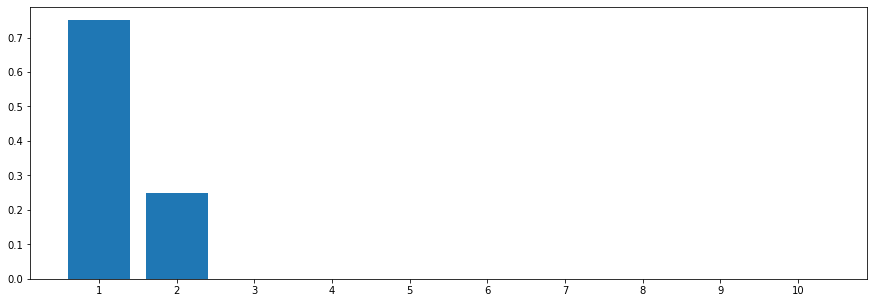

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(X_train)
n_comp = 10
pca = PCA(n_components = n_comp)
pca_vectors = pca.fit_transform(X_train)

plt.figure(figsize=(15,5))
plt.bar(range(1, n_comp+1), pca.explained_variance_ratio_)
plt.xticks(range(1, n_comp+1))
plt.show()

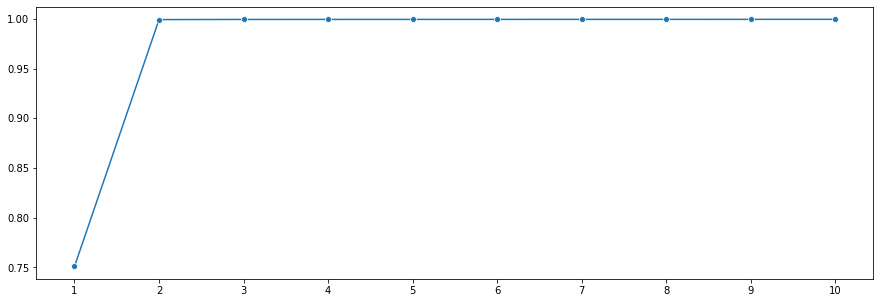

In [ ]:
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

import seaborn as sns
plt.figure(figsize=(15,5))
sns.lineplot(range(1, n_comp+1), cum_explained_var, marker="o")
plt.xticks(range(1, n_comp+1))
plt.show()

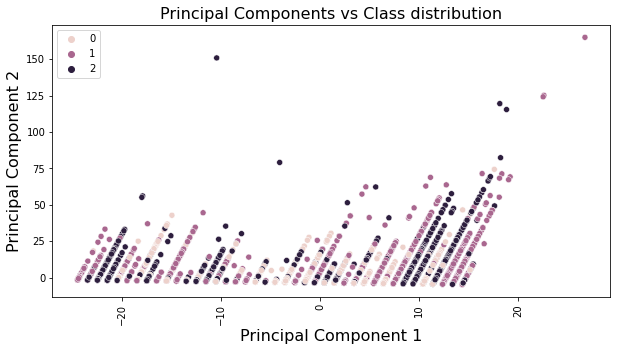

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.scatterplot(x=pca_vectors[:, 0], y=pca_vectors[:, 1], hue=y_train)
plt.title('Principal Components vs Class distribution', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.xticks(rotation='vertical');

## Label Propagation

The basic intuition of label propagation is to assign the label to a node as the label of the majority of neighbors. Intuitively it can be seen as a random walk starting from each node and stopping when arriving on a labeled node.

The matematical formulation is the following:

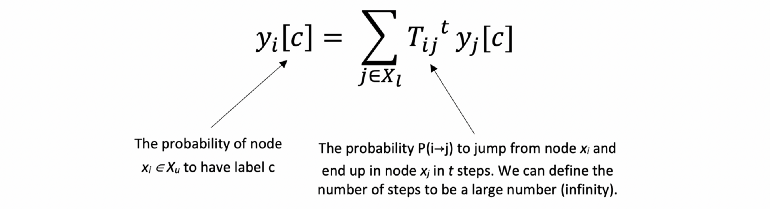

In matrix form:

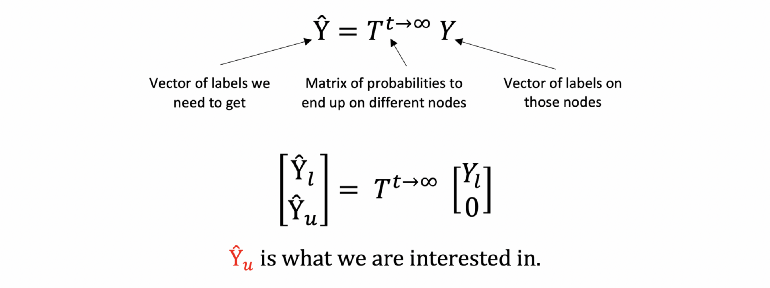

So if we can compute the probabilistic transition matrix $T$, we can compute all the label probabilities of the unlabelled nodes.

We can calculate $T$ using the degree matrix (D) and the adjacency matrix (A) as $T = D^{-1} A$.

For more details I redirect to the [source article](https://medium.com/@urbinati.cri/list/reading-list).

In [ ]:
G = to_networkx(data, to_undirected=True)

A = nx.adjacency_matrix(G) 

D = np.sum(A,1)
D = np.diag(np.array(D)[:,0])
Dinv = np.linalg.inv(D)

T = Dinv*A

Y = np.zeros((data.num_nodes, dataset.num_classes)) # Create an array of zeros with size (number of nodes, number of classes)
train_mask = data.train_mask + data.val_mask        # Consider for the train both train and validation nodes
Y[train_mask, data.y[train_mask]] = 1               # Assign 1 in the index position of that class for nodes in the training set (a node with class 2 will have a mask like [0, 0, 1, ...])
Y = np.matrix(Y)

In [ ]:
%%time

def LabelPropagation(T, Y, diff, max_iter, labelled):
   
    # Initialize
    Y_init = Y
    Y1 = Y
    
    # Initialize convergence parameters
    n=0
    current_diff = sys.maxsize
    
    # Iterate till difference reduces below diff or till the maximum number of iterations is reached
    while current_diff > diff and n < max_iter:
        
        current_diff = 0.0
        # Set Y(t)
        Y0 = Y1
        
        # Calculate Y(t+1)
        Y1 = T*Y0
        
        # Clamp labelled data
        for i in range(Y_init.shape[0]):
            if i in labelled:
                for j in range(Y_init.shape[1]):
                    if i!=j:
                        Y1.A[i][j] = Y_init.A[i][j]
        
        # Get difference between values of Y(t+1) and Y(t)
        for i in range(Y1.shape[0]):
            for j in range(Y1.shape[1]):
                current_diff += abs(Y1.A[i][j] - Y0.A[i][j])
        
        n += 1
        
    return Y1

L = LabelPropagation(T, Y, 0.0001, 100, train_mask)

CPU times: user 6min 40s, sys: 33.9 s, total: 7min 14s
Wall time: 3min 26s


In [ ]:
y_pred = np.asarray(L.argmax(1)).reshape(-1,)[data.test_mask]
print(f'Accuracy on test: {accuracy_score(y_test, y_pred, sample_weight=[normalized_totals_test[x] for x in y_test])*100:.2f}%')

Accuracy on test: 71.65%


# GNN - ML pipeline
ML models exploiting embedding computing with best GNN model

In [ ]:
# Embedding after training
model = ParametrizedGATNet(INPUT_DIM, best_parameters['HIDDEN_DIM'], OUTPUT_DIM, best_parameters['DROPOUT'], best_parameters['N_LAYERS'], best_parameters['N_HEADS'], best_parameters['SKIP_CONN'], best_parameters['POST_PROC_MLP'], return_embedding=True).to(device)
model.load_state_dict(best_model_weights)

emb = None
with torch.no_grad():
    model.eval()
    _, emb = model(data.x.to(device), data.edge_index.to(device))

emb = emb.cpu()


In [ ]:
# X_train and X_test contains the node features
# X_train combines both train and validation splits in order to perform crossvalidation
X_train = pd.DataFrame(emb[data.train_mask].detach().numpy())
#X_train = X_train.append(pd.DataFrame(emb[data.val_mask].detach().numpy()))
X_test = pd.DataFrame(emb[data.test_mask].detach().numpy())
print(f'X_train\tshape: {X_train.shape}\nX_test\tshape: {X_test.shape}')

X_train	shape: (18217, 48)
X_test	shape: (1000, 48)


In [ ]:
# y_train and y_test contains the node labels
y_train = data.y[data.train_mask].detach().numpy().reshape(-1,)
#y_train = np.append(y_train, pd.DataFrame(data.y[data.val_mask].detach().numpy().reshape(-1,)))
y_test = data.y[data.test_mask].detach().numpy().reshape(-1,)
print(f'y_train\tshape: {y_train.shape}\ny_test\tshape: {y_test.shape}')

y_train	shape: (18217,)
y_test	shape: (1000,)


In [ ]:
for score in scores:
    print("========================================")
    print("# Tuning hyper-parameters for {}".format(score))
    for model in models:
        print("----------------------------------------")
        print("Trying model {}".format(models.get(model)["name"]))
        start = time.time()
        clf = GridSearchCV(models.get(model)["estimator"], models.get(model)["param"], scoring='%s_macro' % score)
        clf.fit(X_train, y_train)
        print_results(clf)
        end = time.time()
        print(f"Time elapsed: {(end - start):.2f}s")

# Tuning hyper-parameters for precision
----------------------------------------
Trying model Logistic Regression
Best parameters set found on train set:

{'solver': 'lbfgs'}

Grid scores on train set:

0.976 (+/-0.003) for {'solver': 'lbfgs'}

Detailed classification report for the best parameter set:

Accuracy on test: 88.18%
Time elapsed: 4.26s
----------------------------------------
Trying model Random Forest
Best parameters set found on train set:

{'max_depth': 100}

Grid scores on train set:

0.967 (+/-0.003) for {'max_depth': 100}

Detailed classification report for the best parameter set:

Accuracy on test: 88.97%
Time elapsed: 19.21s
----------------------------------------
Trying model XGBoost
Best parameters set found on train set:

{'objective': 'multi:softmax', 'tree_method': 'gpu_hist'}

Grid scores on train set:

0.968 (+/-0.003) for {'objective': 'multi:softmax', 'tree_method': 'gpu_hist'}

Detailed classification report for the best parameter set:

Accuracy on test: 

No improvement in this case